# K-o'means vs Belief function model


### Data--certain preference
The experiment uses SUSHI Preference Data Set (SUSHI) from real world.
We used order A from SUSHI. In order A, each user ranks 10 sushi by his preferences ( out of 10). So this preference is a total order.

In [526]:
%matplotlib inline
from jpGeoPlot import scatter_on_map, read_geo_info
geo_info = read_geo_info("../data/jap_prefecture_geo_en.csv")

In [8]:
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

import random
import re

from read import read_voter_file, read_score_file, read_order_file
from tools import all_mass_init, all_certain_mass_init, flatten_pref_mass_mat
from beliefKMeans import k_means, silhouette_score, _k_means_single
from beliefDBSCAN import cal_distances
import EKNNclus

vMap = read_voter_file("../data/sushi3-2016/sushi3.udata")
#read_score_file("../data/sushi3-2016/sushi3b.10.score", vMap)
read_order_file("../data/sushi3-2016/sushi3a.5000.10.order", vMap)

In [134]:
order_mat = np.empty((5000,10), dtype=int)
for k in vMap.keys():
    order_mat[k] = np.array(vMap[k].get_order_a(), dtype=int)
X = np.argsort(order_mat)

### Models
Given a set of $N$ alternatives $a_1, a_2, ...a_N$, a total preference order $O$ covers all the alternatives $O = {a_1, a_2, ...a_n}$. The main differences between models exists in the data representation. We used two representations: rank number and belief function model




#### Rank number

we represent an order $O$ by the rank number $r$ of each elements $a_i$. $r(O,a_i) = argsort(O,a_i)$ 
for example, an Order $O_1 = a_3 \succ a_1 \succ a_2$ is represented by $r(O_1, a_1), r(O_1, a_2), r(O_1, a_3)$ {\em i.e.} (2,3,1)

For rank number representation, we applied euclidean metric, spearman correlation, pearson correlation as well as kendall correlation for the dissimilarity measure.


In [10]:
from sklearn.metrics.pairwise import euclidean_distances
import sklearn.metrics 

We use EKNNclus for clustering with K varing from 10 to 95 with step=5

In [18]:
l1_dist_mat = euclidean_distances(X,X)
result = {}
for K in range(10, 100, 5):
    labels = EKNNclus.EKNNclus_Th(X, K=K, D = l1_dist_mat , 
                            ntrials=20, y0 = list(range(X.shape[0])),tr = False)
    result[K] = (labels, sklearn.metrics.silhouette_score(X, labels))
#euc_ss = sklearn.metrics.silhouette_score(X, labels)

0 1 4469 1114
0 2 1617 539
0 3 823 417
0 4 367 365
0 5 232 343
0 6 148 334
0 7 89 325
0 8 42 323
0 9 46 320
0 10 21 320
0 11 19 317
0 12 12 315
0 13 8 314
0 14 0 314
1 1 4463 1092
1 2 1609 528
1 3 742 426
1 4 421 376
1 5 254 343
1 6 138 329
1 7 76 322
1 8 31 319
1 9 23 318
1 10 16 316
1 11 12 315
1 12 2 315
1 13 1 315
1 14 0 315
2 1 4474 1062
2 2 1557 542
2 3 774 429
2 4 444 370
2 5 276 337
2 6 152 320
2 7 80 303
2 8 42 300
2 9 15 299
2 10 5 299
2 11 4 298
2 12 0 298
3 1 4470 1096
3 2 1672 523
3 3 772 392
3 4 404 345
3 5 264 317
3 6 170 298
3 7 92 288
3 8 38 286
3 9 14 285
3 10 11 285
3 11 5 285
3 12 0 285
4 1 4462 1098
4 2 1606 544
4 3 812 421
4 4 430 365
4 5 253 342
4 6 156 322
4 7 91 317
4 8 53 314
4 9 46 312
4 10 22 309
4 11 9 309
4 12 2 309
4 13 0 309
5 1 4485 1073
5 2 1628 533
5 3 813 402
5 4 454 344
5 5 264 320
5 6 167 297
5 7 83 291
5 8 34 289
5 9 16 287
5 10 8 287
5 11 4 287
5 12 10 286
5 13 4 285
5 14 0 285
6 1 4467 1082
6 2 1577 533
6 3 744 418
6 4 442 375
6 5 262 344
6 6 17

In [234]:
print(np.mean(l1_dist_mat), np.std(l1_dist_mat))

11.2267576336 2.7080169415


In [313]:
for K in range(10, 100, 5):
    print(K,result[K][1], len(np.unique(result[K][0])))

10 -0.0267354732412 276
15 -0.114710001355 148
20 -0.222993362463 51
25 -0.137456868831 16
30 -0.101238489461 10
35 0.0552429716164 7
40 0.139477184079 4
45 0.0895105268604 7
50 0.0994829497714 6
55 0.101812972537 6
60 0.138591153913 4
65 0.124227314492 5
70 0.149053300036 3
75 0.148273676223 3
80 0.147727210798 3
85 0.147931318648 3
90 0.188779630532 2
95 0.147393556647 3


## Spearman distance, pearson distance & kendall distance

We also apply spearman, pearson, kendall correlation measure to measure dissimilarity

In [254]:
from scipy.stats import spearmanr, pearsonr, kendalltau
n_samples = 5000
spearman_rho_mat= np.zeros((n_samples,n_samples))
pearson_mat = np.zeros((n_samples,n_samples))
kendall_mat = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    for j in range(i+1, n_samples):
        spearman_rho_mat[i][j] = spearmanr(order_mat[i], order_mat[j])[0]
        pearson_mat[i][j] = pearsonr(order_mat[i], order_mat[j])[0]
        kendall_mat[i][j] = kendalltau(order_mat[i], order_mat[j])[0]
spearman_rho_mat += spearman_rho_mat.T
pearson_mat += pearson_mat.T
kendall_mat += kendall_mat.T

In [295]:
kendall_mat

array([[ 0.        ,  1.02222222,  0.48888889, ...,  0.84444444,
         1.06666667,  1.02222222],
       [ 1.02222222,  0.        ,  1.06666667, ...,  1.33333333,
         1.11111111,  0.8       ],
       [ 0.48888889,  1.06666667,  0.        , ...,  0.53333333,
         0.66666667,  1.06666667],
       ..., 
       [ 0.84444444,  1.33333333,  0.53333333, ...,  0.        ,
         1.2       ,  1.51111111],
       [ 1.06666667,  1.11111111,  0.66666667, ...,  1.2       ,
         0.        ,  0.66666667],
       [ 1.02222222,  0.8       ,  1.06666667, ...,  1.51111111,
         0.66666667,  0.        ]])

In [309]:
result_spk = {}
for K in range(10, 100, 10):
    labels_spearman = EKNNclus.EKNNclus_Th(order_mat, K=K, D = spearman_mat , 
                            ntrials=10, y0 = list(range(order_mat.shape[0])),tr = False)
    labels_pearson = EKNNclus.EKNNclus_Th(order_mat, K=K, D = pearson_mat , 
                            ntrials=10, y0 = list(range(order_mat.shape[0])),tr = False)
    labels_kendall = EKNNclus.EKNNclus_Th(order_mat, K=K, D = kendall_mat , 
                            ntrials=10, y0 = list(range(order_mat.shape[0])),tr = False)
    result_spk[K] = {"spearman":(labels_spearman, silhouette_score(order_mat, labels_spearman, distances=spearman_mat) if len(np.unique(labels_spearman))>1 else None),
                     "pearson": (labels_pearson, silhouette_score(order_mat, labels_pearson, distances=pearson_mat) if len(np.unique(labels_pearson))>1 else None),
                     "kendall": (labels_kendall, silhouette_score(order_mat, labels_kendall, distances=kendall_mat) if len(np.unique(labels_kendall))>1 else None )}

0 1 4128 1407
0 2 1290 821
0 3 440 700
0 4 176 668
0 5 92 654
0 6 46 643
0 7 15 643
0 8 5 642
0 9 1 642
0 10 0 642
1 1 4119 1360
1 2 1293 821
1 3 492 696
1 4 205 643
1 5 85 628
1 6 38 617
1 7 16 614
1 8 8 614
1 9 2 614
1 10 0 614
2 1 4130 1407
2 2 1324 820
2 3 524 683
2 4 235 632
2 5 99 616
2 6 41 611
2 7 12 609
2 8 8 609
2 9 2 608
2 10 1 608
2 11 0 608
3 1 4143 1384
3 2 1261 815
3 3 456 696
3 4 159 654
3 5 52 647
3 6 32 640
3 7 10 639
3 8 2 639
3 9 0 639
4 1 4155 1337
4 2 1213 793
4 3 462 681
4 4 178 635
4 5 85 618
4 6 44 610
4 7 14 609
4 8 7 609
4 9 3 608
4 10 1 608
4 11 0 608
5 1 4147 1355
5 2 1263 817
5 3 510 689
5 4 215 641
5 5 98 613
5 6 37 607
5 7 16 604
5 8 2 603
5 9 0 603
6 1 4136 1369
6 2 1330 798
6 3 432 683
6 4 168 644
6 5 77 630
6 6 27 624
6 7 12 622
6 8 6 621
6 9 2 620
6 10 0 620
7 1 4129 1387
7 2 1301 826
7 3 476 683
7 4 198 644
7 5 99 625
7 6 42 616
7 7 21 612
7 8 16 609
7 9 4 608
7 10 0 608
8 1 4113 1409
8 2 1302 838
8 3 506 707
8 4 211 653
8 5 87 633
8 6 37 628
8 7 16

In [315]:
for K in range(10, 100, 10):
    print(K, result_spk[K]["spearman"][1] ,len(np.unique(result_spk[K]["spearman"][0])))
for K in range(10, 100, 10):
    print(K, result_spk[K]["pearson"][1],len(np.unique(result_spk[K]["pearson"][0])) )
for K in range(10, 100, 10):
    print(K, result_spk[K]["kendall"][1],len(np.unique(result_spk[K]["kendall"][0])) )

10 0.118783973175 608
20 -0.0339359013311 261
30 -0.0644585085626 141
40 -0.254812331091 7
50 -0.118360346156 3
60 -0.074214328069 2
70 -0.0500553941071 2
80 None 1
90 None 1
10 0.124857419578 613
20 -0.00903354203295 265
30 -0.354641005206 39
40 -0.111731972613 3
50 -0.0498970178034 2
60 -0.0486280091982 2
70 -0.0755626799242 2
80 -0.0518282558135 2
90 None 1
10 0.0795879219338 471
20 -0.057927864281 226
30 -0.250630113242 11
40 -0.108451746511 3
50 None 1
60 None 1
70 -0.0423667487218 2
80 None 1
90 None 1


In [250]:
print(rho_mat[0][1],pval_mat[0][1], order_mat[0], order_mat[1])

-0.229543377895 8.78484457406e-61 [5 0 3 4 6 9 8 1 7 2] [0 9 6 3 7 2 8 1 5 4]


In [253]:
order_mat[1]

array([0, 9, 6, 3, 7, 2, 8, 1, 5, 4])

# Belief function model without uncertainty

#### Belief function model

For preference without uncertainty, for any alternative pair $a_i, a_j$, the mass function is dogmatic and simple support with 1 on singleton $\omega _1$ or $\omega_2$ (corresponding to strict prefer or strict inversed prefer)

The dissimilarity function is applied by Jousselme distance.

In [419]:
def seq2bf(seq):
    """
    Transfer a preference sequence into pairwise belief function reprsentation
    We assume that the given sequence is rational (the elements are "continuous")
    """
    elements = sorted(seq)
    element_nb = len(seq)
    vect_size = int((element_nb-1)*element_nb/2)
    #print(vect_size)
    mass_vect = np.zeros((vect_size, 16), dtype=object)
    cpt=0
    for i in elements:
        for j in elements:
            if i<j:
                bf = np.zeros((16))
                #print(bf)
                if np.argwhere(seq==i)<np.argwhere(seq==j): #seq.index(i)<seq.index(j):
                    bf[1] = 1
                else:
                    bf[2] = 1
                #print((i-1)*element_nb+j-1)
                mass_vect[cpt] = bf
                cpt += 1
    return mass_vect
#mass = seq2bf(np.array([5, 0, 3, 4, 6, 9, 8, 1, 7, 2]))
#print(mass)

In [420]:
mass = seq2bf(np.array([5, 0, 3, 4, 6, 9, 8, 1, 7, 2]))
mass.shape

(45, 16)

In [421]:
X_bf = np.apply_along_axis(seq2bf, 1, order_mat)

In [41]:
dist_mat = cal_distances(X_bf, 'jousselme')

In [233]:
print(np.mean(dist_mat), np.std(dist_mat))

0.426175402667 0.137626585642


In [43]:
from beliefKMeans import k_means, silhouette_score, _k_means_single

In [214]:
result_bf = {}
for K in range(10, 100, 5):
    labels = EKNNclus.EKNNclus_Th(X_bf, K=K, D = dist_mat , 
                            ntrials=20, y0 = list(range(X.shape[0])),tr = False)
    result_bf[K] = (labels, silhouette_score(X_bf, labels, distances = dist_mat))
#euc_ss = sklearn.metrics.silhouette_score(X, labels)

0 1 4367 1263
0 2 1584 640
0 3 759 488
0 4 388 429
0 5 242 400
0 6 140 385
0 7 101 374
0 8 61 369
0 9 21 366
0 10 23 365
0 11 30 364
0 12 16 362
0 13 14 359
0 14 0 359
1 1 4320 1296
1 2 1665 674
1 3 820 509
1 4 425 452
1 5 253 422
1 6 124 411
1 7 112 398
1 8 63 392
1 9 60 388
1 10 30 386
1 11 18 385
1 12 8 383
1 13 6 383
1 14 10 381
1 15 0 381
2 1 4353 1256
2 2 1579 651
2 3 691 509
2 4 389 454
2 5 257 424
2 6 150 404
2 7 87 398
2 8 60 388
2 9 36 384
2 10 31 381
2 11 16 379
2 12 11 378
2 13 7 378
2 14 3 377
2 15 1 377
2 16 0 377
3 1 4354 1263
3 2 1684 638
3 3 792 492
3 4 441 431
3 5 281 388
3 6 164 369
3 7 99 358
3 8 81 354
3 9 75 348
3 10 48 344
3 11 27 341
3 12 18 338
3 13 17 337
3 14 13 334
3 15 3 334
3 16 0 334
4 1 4331 1267
4 2 1632 664
4 3 797 499
4 4 407 446
4 5 262 424
4 6 178 401
4 7 77 387
4 8 50 380
4 9 34 378
4 10 18 377
4 11 6 376
4 12 4 375
4 13 0 375
5 1 4343 1256
5 2 1657 648
5 3 750 512
5 4 410 456
5 5 244 426
5 6 161 403
5 7 102 391
5 8 77 385
5 9 47 382
5 10 36 380
5 

In [316]:
for K in range(10, 100, 5):
    print(K, result_bf[K][1], len(np.unique(result_bf[K][0])))

10 -0.0581608009003 334
15 -0.289012163494 95
20 -0.272144539911 36
25 -0.168311207343 11
30 -0.0194546429402 9
35 0.113503649857 6
40 0.103905127901 5
45 0.0676118235815 5
50 0.177507727783 3
55 0.17570785943 3
60 0.176304413329 3
65 0.176058077372 3
70 0.173827175842 3
75 0.150703539125 4
80 0.174987810419 3
85 0.0964697937042 4
90 0.17269823478 3
95 0.237309401712 2


### Compare between clustering results under two models

By comparing silhouette score, we can not arbitrarily conclude one is better than the other (silhouette scores are similar)

We use ARI (Rand index adjusted) to compaire two clustering results

In [144]:
from sklearn.metrics.cluster import adjusted_rand_score
X_order = np.argsort(order_mat)
order_dist_mat = euclidean_distances(X_order,X_order)
ARI_dict = {}
for K in range(10, 100, 5):
    labels_order_1 = EKNNclus.EKNNclus_Th(X_order, K=K, D = order_dist_mat , 
                            ntrials=20, y0 = list(range(X.shape[0])),tr = False)
    labels_order_2 = EKNNclus.EKNNclus_Th(X_bf, K=K, D = dist_mat , 
                            ntrials=20, y0 = list(range(X.shape[0])),tr = False)
    ARI_dict[K]=adjusted_rand_score(labels_order_1, labels_order_2)

0 1 4492 1112
0 2 1653 524
0 3 748 404
0 4 415 347
0 5 216 326
0 6 100 313
0 7 68 303
0 8 51 299
0 9 24 296
0 10 20 295
0 11 13 294
0 12 11 294
0 13 5 293
0 14 2 293
0 15 0 293
1 1 4471 1089
1 2 1580 547
1 3 818 424
1 4 456 363
1 5 240 336
1 6 161 320
1 7 72 310
1 8 35 305
1 9 11 305
1 10 10 304
1 11 4 303
1 12 0 303
2 1 4449 1080
2 2 1603 546
2 3 789 422
2 4 458 367
2 5 297 323
2 6 182 311
2 7 101 299
2 8 55 293
2 9 28 292
2 10 20 291
2 11 15 289
2 12 3 288
2 13 0 288
3 1 4454 1109
3 2 1662 523
3 3 730 426
3 4 418 371
3 5 267 339
3 6 165 319
3 7 82 311
3 8 60 308
3 9 39 304
3 10 33 303
3 11 30 298
3 12 8 297
3 13 1 297
3 14 0 297
4 1 4480 1099
4 2 1637 531
4 3 766 409
4 4 389 359
4 5 213 339
4 6 165 329
4 7 102 321
4 8 68 313
4 9 47 310
4 10 25 309
4 11 27 308
4 12 10 307
4 13 16 305
4 14 5 304
4 15 2 304
4 16 0 304
5 1 4475 1081
5 2 1591 537
5 3 789 421
5 4 463 363
5 5 245 332
5 6 125 321
5 7 81 314
5 8 51 308
5 9 41 305
5 10 20 304
5 11 13 303
5 12 15 303
5 13 11 303
5 14 6 302
5 15

In [145]:
ARI_dict

{10: 0.24871314455484309,
 15: 0.11765410393319842,
 20: 0.70765147597748046,
 25: 0.72979121448897744,
 30: 0.69364834282432031,
 35: 0.87343622656793674,
 40: 0.84905663293535227,
 45: 0.81959999978564901,
 50: 0.85250771521314628,
 55: 0.8350044983325976,
 60: 0.90436577270041274,
 65: 0.88907028173563096,
 70: 0.82904348357956881,
 75: 0.91379790404357841,
 80: 0.79317360027442729,
 85: 0.92386680002105015,
 90: 0.80356586094484128,
 95: 0.92667063163949315}

/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


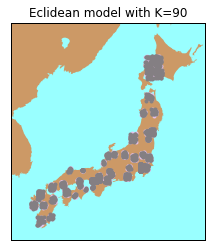

In [527]:
import importlib

jpGeoPlot = importlib.reload(jpGeoPlot)

jpGeoPlot.scatter_on_map(vMap,result[90][0], geo_info, title = "Eclidean model with K=90", mode=2)


/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


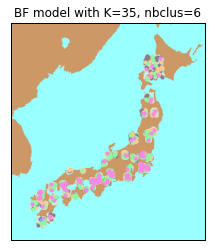

In [528]:
jpGeoPlot.scatter_on_map(vMap,result_bf[35][0] , geo_info, title = "BF model with K=35, nbclus=6", mode=2)


### A new evaluation method: Fusion the users in identical clusters
We try fusion the individuals in the same cluster to evaluate the clustering result.
To avoid empty set converging to 1, we apply Stragegy B.

** In terms of intra-cluster: **

In one identical cluster, if individuals have similar preference (i.e. similar value on the same relations), the fusioned result should have values close to 1 on one relation and 0 on the others for all pairs. This can also be interpreted as following: for one pair $a_i, a_j$, the values on each elements in the mass function have a big variance (for example, startd deviation).

An extreme case: for one pair $a_i,a_j$,  if all individuals have 1 on strict preference, the fusioned result has 1 on strict preference and 0 on inverse preference, indifference and incomparability. In this case, the stand deviation is 0.25 ($|\Omega |=4$)

Other extreme case: in a cluster $C_{example}$ having 16 individuals,  for one pair $a_i, a_j$, each inidividuals has value 1 on different elements. The fusioned BF (with mean value strategy) becomes 
$ [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]$, 

with standart deviation = 0.

**In terms of inter-cluster**

A well distinguished culstering result should have apparent difference among clusters.

Extreme Example: Two clusters with complete different preferences:

In [525]:
extreme1 = np.zeros((45, 16))
extreme1.T[1] = 1.0
extreme2 = np.zeros((45, 16))
extreme2.T[2] = 1.0
cal_distances(np.array([extreme1, extreme2]), 'jousselme')

array([[ 0.,  1.],
       [ 1.,  0.]])

** To concluse: **

a good clustering result should have following properties: 
denote $F(C_k)$ the fusioned mass function on all pairs preferences of cluster k
1. for alternative pair $a_i, a_j$, $m_{ij} \in F(C_k) \approx 1$
2. for any cluster pair $C_{k1}, C{k2}$, dissimilarity $D_{Jousselme}(C_{k1}, C_{k2}) \approx 1$

### Now we caclculate the fusioned preference on the data from the real world

In [411]:
labels_K = result_bf[40][0]
n_pairs=X_bf.shape[1]
clusters = np.unique(labels_K)
n_pairs,clusters

(45, array([0, 1, 2, 3, 4]))

In [503]:
from iBelief.combinationRules import DST
X_fusioned = np.zeros((clusters.size, n_pairs, 16))
for clus in clusters:
    for p in range(n_pairs):
        #import pdb; pdb.set_trace()
        # As for certain preference, all BF are Single supported function, 
        # we can directly apply a mean value fusion method (Equivalent to Strategy B)
        X_fusioned[clus][p] = DST(np.transpose(X_bf[np.where(labels_K == clus)[0]], (1,0,2))[p].T, 12).T[0]

In [508]:
fusioned_dist_mat = cal_distances(X_fusioned, 'jousselme')

In [509]:
fusioned_dist_mat

array([[ 0.        ,  0.27424183,  0.27600281,  0.47996402,  0.25580657],
       [ 0.27424183,  0.        ,  0.24859986,  0.32387085,  0.20553655],
       [ 0.27600281,  0.24859986,  0.        ,  0.37314178,  0.18054471],
       [ 0.47996402,  0.32387085,  0.37314178,  0.        ,  0.4005144 ],
       [ 0.25580657,  0.20553655,  0.18054471,  0.4005144 ,  0.        ]])

# Clustering with generated 2nd source: score

In this part, we randomly generate scores with a uniform distribution. And the fusioned result with the two models


## Traditional model

In [74]:
#Generate scores 1-5 to 10 sushi 
score_mat = np.random.choice(range(1,5), (5000, 10))

In [76]:
#Normalized order is obtained by reversed order and transfered to range (0-5)
order_mat_normalize = (10-np.argsort(order_mat))/2

X_mean = (order_mat_normalize+score_mat)/2
# X_mean is the mean value of score and order

In [77]:
l1_dist_mat_fusioned = euclidean_distances(X_mean,X_mean)
result_fusioned = {}
for K in range(10, 100, 5):
    labels = EKNNclus.EKNNclus_Th(X_mean, K=K, D = l1_dist_mat_fusioned , 
                            ntrials=20, y0 = list(range(X_mean.shape[0])),tr = False)
    result_fusioned[K] = (labels, sklearn.metrics.silhouette_score(X_mean, labels))

0 1 4485 1246
0 2 1864 524
0 3 935 378
0 4 600 305
0 5 430 267
0 6 271 242
0 7 210 229
0 8 183 221
0 9 149 208
0 10 162 201
0 11 135 197
0 12 117 190
0 13 119 186
0 14 139 178
0 15 102 174
0 16 98 172
0 17 105 168
0 18 99 165
0 19 80 161
0 20 120 156
0 21 167 147
0 22 175 141
0 23 182 132
0 24 212 128
0 25 291 118
0 26 345 105
0 27 382 90
0 28 407 78
0 29 440 62
0 30 404 48
0 31 328 35
0 32 238 17
0 33 117 7
0 34 38 4
0 35 7 3
0 36 0 3
1 1 4468 1236
1 2 1887 548
1 3 952 391
1 4 575 327
1 5 392 291
1 6 301 269
1 7 211 255
1 8 176 242
1 9 136 233
1 10 110 228
1 11 86 224
1 12 79 219
1 13 65 215
1 14 76 212
1 15 70 208
1 16 67 205
1 17 47 201
1 18 70 198
1 19 87 197
1 20 106 190
1 21 166 184
1 22 120 172
1 23 112 168
1 24 110 163
1 25 142 156
1 26 159 150
1 27 180 145
1 28 312 137
1 29 375 122
1 30 443 101
1 31 482 80
1 32 442 60
1 33 358 41
1 34 264 34
1 35 208 25
1 36 202 15
1 37 159 12
1 38 141 9
1 39 118 6
1 40 49 4
1 41 19 4
1 42 17 4
1 43 22 4
1 44 18 4
1 45 1 3
1 46 0 3
2 1 4496 12

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [232]:
print(np.mean(l1_dist_mat_fusioned), np.std(l1_dist_mat_fusioned))

3.71678455398 0.821901982773


In [224]:
labels_incertain = EKNNclus.EKNNclus_Th(X_mean, K=2, D = l1_dist_mat_fusioned, ntrials=10, 
                              y0 = list(range(X_mean.shape[0])),tr = False)
print(np.unique(labels))

0 1 3926 1809
0 2 1062 1239
0 3 265 1112
0 4 57 1084
0 5 9 1080
0 6 3 1079
0 7 1 1078
0 8 0 1078
1 1 3920 1829
1 2 1061 1239
1 3 230 1111
1 4 45 1087
1 5 5 1084
1 6 0 1084
2 1 3919 1821
2 2 1059 1252
2 3 278 1111
2 4 52 1087
2 5 8 1082
2 6 1 1081
2 7 0 1081
3 1 3917 1788
3 2 1013 1220
3 3 234 1107
3 4 51 1082
3 5 7 1077
3 6 0 1077
4 1 3924 1828
4 2 1076 1238
4 3 248 1112
4 4 50 1085
4 5 14 1079
4 6 3 1076
4 7 0 1076
5 1 3911 1803
5 2 1009 1253
5 3 281 1121
5 4 49 1090
5 5 7 1087
5 6 1 1086
5 7 0 1086
6 1 3917 1809
6 2 1007 1232
6 3 239 1112
6 4 55 1083
6 5 7 1079
6 6 0 1079
7 1 3921 1828
7 2 1089 1253
7 3 281 1122
7 4 66 1094
7 5 9 1089
7 6 0 1089
8 1 3918 1813
8 2 1021 1242
8 3 270 1121
8 4 67 1089
8 5 8 1084
8 6 2 1082
8 7 0 1082
9 1 3918 1801
9 2 1025 1229
9 3 260 1123
9 4 64 1093
9 5 21 1085
9 6 1 1084
9 7 0 1084
[0 1]


In [185]:
sklearn.metrics.silhouette_score(X_mean, labels)

-0.090269309646338225

#### Conclusion: 
Silhouette score shows that:
The traditional representation can not deal with randomly generated score (a random source).
The individuals are not distinguished well.

## Belief function model

In [137]:
def _score_2_order_mat(score, nbItem = 10):
    #print(score)
    shape = (nbItem,nbItem)
    orderMat = np.full(shape, -1, dtype = int)
    #np.fill_diagonal(orderMat,1)
    for i in range(nbItem):
        for j in range(nbItem):
            if i <= j:
                #if v1 > v2:
                if score[i] >score[j]:
                    orderMat[i][j] = 1
                    orderMat[j][i] = 0
                elif score[i] < score[j]:
                    orderMat[i][j] = 0
                    orderMat[j][i] = 1
                else:
                    orderMat[i][j] = 1
                    orderMat[j][i] = 1
    return orderMat
def _seq_2_order_mat(seq, nbItem = 10):
    seq=seq-1
    if max(seq)>nbItem:
        raise IllegalItemNumberError("Preference Sequence size is larger than the given item numbers. (should be smaller or equal)")
    else:
        shape = (nbItem, nbItem)
        orderMat = np.full(shape, -1, dtype = int)
        #sortedSeq = sorted(seq)
        for i in seq:
            for j in seq:
                ind1 = np.argwhere(seq==i)[0][0]#seq.index(i)
                ind2 = np.argwhere(seq==j)[0][0]#seq.index(j)
                #print(seq,i,j,ind1,ind2)
                if ind1 < ind2:
                    orderMat[i][j] = 1
                    orderMat[j][i] = 0
                elif ind1 > ind2:
                    orderMat[i][j] = 0
                    orderMat[j][i] = 1
                else:
                    orderMat[i][j] = 1
    return orderMat
def fargin_distance(scoreMat, seqMat, tiePenalty = 0.5):
    """
    Calculate Fargin distance with ties.
    The score and sequence are on the same group of items, so is an complete order.
    By matricial calculating, each pair is counted once, so we use 0.5 as default penalty value.
    """
    print(scoreMat, seqMat)
    if scoreMat.shape == seqMat.shape:
        m = scoreMat - seqMat
        n_pairs = m.shape[1] ** 2
        #print(m)
        discoTie = np.count_nonzero(m + np.transpose(m)) / 2
        #print("Tie Mat: \n",discoTie)
        discoInv = (np.count_nonzero(m) - discoTie) / 2
        #print("Inverse Mat: \n", discoInv)
        faginDistance = discoInv + discoTie * tiePenalty
        #print("m shape: \n", m.shape)
        normalized_fargin_distance = faginDistance / n_pairs
        if normalized_fargin_distance > 1:
            print(m)
            raise ValueError("normalized fargin distance %f is bigger than 1 (Tie: %d, inverse: %d, pair number:%d)" 
                             % (normalized_fargin_distance, discoTie, discoInv, m.shape[1]))
        return normalized_fargin_distance
    else:
        raise IllegalMatrixShapeError("Given score shape and sequence shape are not the same (%s, %s)" 
                                      % (scoreMat.shape, seqMat.shape))
def _one_mass_init(r1, r2, ignorance = 1.0):
    """
    """
    if r1 > 4 or r2 > 4:
        raise ValueError("r1 and r2 should be smaller than 4. However, %d and %d are given." % (r1,r2))
    #elif r1<4 and r1==r2:

        #raise ValueError("r1 and r2 representing two conflictual relations should not be identical. However %d and %d are given " %(r1, r2))
    if ignorance <0 or ignorance > 1:
        raise ValueError("Ignorance value should be betwwen 0 and 1. Hoever, %f is given (and r1=%d r2=%d)" % (ignorance,r1,r2))
    else:
        mass = np.zeros(vector_size)
        if r1==r2:
            if r1==4:
                pass
            else:
                mass[int(2 ** r1)] = 1 - ignorance
        else:
            mass_value = (1 - ignorance) / (float(r1 < 4) + float(r2 < 4))
            if r1 <= 3:   #relation  = 0,1,2,3
                mass[int(2 ** r1) ] = mass_value
            if r2 <= 3:
                mass[int(2 ** r2) ] = mass_value
        mass[-1] = ignorance
        return mass
def all_mass_init(scores, seqs, candList,vector_size, nbItem = 10):
    """
    initiate mass function values for a voter. if the candidate space is not in [1,100], we convert the candidate by candList to avoid sparse matrix.
    Parameters:
    -----------
    scoreMap: dict of size 10.
        score on given candidate
    seq: list of size 10.
        preference sequence
    candList: list
        candidate space of all given voters.
    nbItem: int
        number of global candidate, 100 by default
    Return:
    -------
    massMat: matrix of 3 dimensions
    """
    #seqs = seqs-1 # to guarantee that seq starts from 0
    farginDist = fargin_distance(_score_2_order_mat(scores, nbItem=nbItem),
                                 _seq_2_order_mat(seqs, nbItem=nbItem))
    print(scores, seqs,farginDist)
    #convert_dict = {x:i for i,x in enumerate(candList)}
    given_cand_nb = len(candList)
    massMat = np.zeros((given_cand_nb, given_cand_nb, vector_size), dtype = object)
    for i in range(given_cand_nb):
        for j in range(i+1, given_cand_nb):
            r1, r2 = 3,3
            #print(i,j)
            if candList[i] not in seqs or candList[j] not in seqs:
                massMat[i][j] = _one_mass_init(r1, r2, 1.0)
            else:
                if np.argwhere(seqs==candList[i])[0] > np.argwhere(seqs==candList[j])[0]:#seqs.index(candList[i]) > seqs.index(candList[j]):
                    r1 = 1
                else:
                    r1 = 0
                if scores[candList[i]-1] > scores[candList[j]-1]:
                    r2 = 0
                elif scores[candList[i]-1] < scores[candList[j]-1]:
                    r2 = 1
                else:
                    r2 = 2

                massMat[i][j] = _one_mass_init(r1, r2, farginDist)
    return massMat

def flatten_pref_mass_mat(square_mat):
    """
    Flatten a preference square matrix into a vector

    Parameter
    ----------------------------
    square_mat: Cartesian product of items, elements in upper triangle with setoff=1 represent preference pairs by mass function.

    Return
    ----------------------------
    flattened_mass: flattened matrix from square mat.
    """
    size = square_mat.shape[1]
    iu = np.triu_indices(size, 1) # diagnoal offset = 1
    flattened_mass = square_mat[iu]
    return flattened_mass
"""
candList = list(range(1,4))
score_test = np.array([[4,3,5], [5,3,1], [2,3,1]])
order_test = np.array([[2,3,1], [1,2,3],[2,1,3]])


n_item = 3
n_sample = 3
vector_size = 16
n_pref_pair = int(n_item*(n_item-1)/2)
X = np.empty((n_sample, n_pref_pair, vector_size),dtype = object)
for k in range(n_sample):
    #print(v.get_order_a())
    X[k] = flatten_pref_mass_mat(all_mass_init(score_test[k], order_test[k], candList, vector_size, nbItem = n_item))
"""

'\ncandList = list(range(1,4))\nscore_test = np.array([[4,3,5], [5,3,1], [2,3,1]])\norder_test = np.array([[2,3,1], [1,2,3],[2,1,3]])\n\n\nn_item = 3\nn_sample = 3\nvector_size = 16\nn_pref_pair = int(n_item*(n_item-1)/2)\nX = np.empty((n_sample, n_pref_pair, vector_size),dtype = object)\nfor k in range(n_sample):\n    #print(v.get_order_a())\n    X[k] = flatten_pref_mass_mat(all_mass_init(score_test[k], order_test[k], candList, vector_size, nbItem = n_item))\n'

In [138]:
candList = list(range(1,11))
n_item = 10
n_sample = order_mat.shape[0]
vector_size = 16
n_pref_pair = int(n_item*(n_item-1)/2)
X = np.empty((n_sample, n_pref_pair, vector_size),dtype = object)
for k in range(n_sample):
    #print(score_mat[k], order_mat[k])
    X[k] = flatten_pref_mass_mat(all_mass_init(score_mat[k], order_mat[k], candList, vector_size, nbItem = n_item))

[[1 1 1 0 0 1 0 0 0 0]
 [1 1 1 0 0 1 0 0 0 0]
 [1 1 1 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 0 0 0 1]
 [1 1 1 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 0 1 0 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 0 0 0 1]] [[1 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 1 0]
 [1 1 0 1 0 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 1 1 1 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 1 0]
 [1 1 1 1 0 1 1 1 1 1]]
[1 1 1 4 2 1 4 3 4 2] [5 0 3 4 6 9 8 1 7 2] 0.22
[[1 1 0 1 0 1 1 1 1 0]
 [1 1 0 1 0 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 0 1 0 0 0 0]
 [1 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 0 1 0 0]
 [1 1 0 1 0 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]] [[1 0 0 1 1 0 0 0 0 0]
 [1 1 0 1 1 0 0 1 0 0]
 [1 1 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 0 1 1 0 1 1 0 0]
 [1 0 0 1 1 0 0 1 0 0]
 [1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]]
[3 3 4 1 4 1 3 2 3 4] [0 9 

In [142]:
#Time costing!!!
bf_incertain_dist_mat = cal_distances(X, 'jousselme')

In [231]:
print(np.mean(bf_incertain_dist_mat), np.std(bf_incertain_dist_mat))

0.280852918739 0.0538045819964


In [333]:
labels_bf_incertain = EKNNclus.EKNNclus_Th(X, K=5, D = bf_incertain_dist_mat, ntrials=10, 
                              y0 = list(range(X.shape[0])),tr = False)

0 1 4083 1681
0 2 1340 1006
0 3 495 819
0 4 224 758
0 5 79 732
0 6 35 725
0 7 17 720
0 8 4 718
0 9 0 718
1 1 4094 1673
1 2 1326 994
1 3 536 814
1 4 210 742
1 5 57 718
1 6 13 713
1 7 7 711
1 8 0 711
2 1 4086 1685
2 2 1380 993
2 3 546 800
2 4 204 741
2 5 99 716
2 6 36 705
2 7 16 700
2 8 3 700
2 9 1 700
2 10 1 700
2 11 1 700
2 12 0 700
3 1 4091 1667
3 2 1409 996
3 3 557 791
3 4 178 732
3 5 111 706
3 6 27 696
3 7 9 693
3 8 12 691
3 9 2 690
3 10 0 690
4 1 4097 1682
4 2 1384 993
4 3 485 826
4 4 217 767
4 5 86 740
4 6 33 727
4 7 6 726
4 8 4 725
4 9 3 725
4 10 1 725
4 11 3 724
4 12 0 724
5 1 4082 1638
5 2 1351 989
5 3 541 811
5 4 216 742
5 5 81 718
5 6 25 707
5 7 8 703
5 8 4 703
5 9 0 703
6 1 4080 1641
6 2 1369 1002
6 3 559 808
6 4 224 740
6 5 88 718
6 6 43 705
6 7 16 703
6 8 6 701
6 9 2 699
6 10 0 699
7 1 4104 1690
7 2 1395 995
7 3 524 808
7 4 207 740
7 5 88 720
7 6 36 707
7 7 12 704
7 8 3 703
7 9 4 702
7 10 1 701
7 11 0 701
8 1 4105 1663
8 2 1403 968
8 3 551 795
8 4 229 724
8 5 99 696
8 6 34

In [334]:
len(np.unique(labels_bf_incertain))

679

In [335]:
silhouette_score(X, labels_bf_incertain, distances = bf_incertain_dist_mat)

-0.028002757957291801

In [219]:
adjusted_rand_score(labels_uncertain, labels_bf_incertain)

-0.0034962705228873052

## Conflict as dissimilarity

In [318]:
from beliefKMeans import _user_conflict
conflict_mat = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        conflict_mat[i][j] = _user_conflict(X[i], X[j])
conflict_mat+=conflict_mat.T

KeyboardInterrupt: 

In [323]:
len(np.where(conflict_mat != 0)[1])

7302787

# Result Plotting
We now plot clustering result on Japan's terretory


Plot certain data clustring with traditional model

In [241]:

scatter_on_map(vMap,result[70][0] , geo_info)

/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/yzhang/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


## Classifier: DBSCAN
Now we try another clustering method: DBSCAN

### On certain data
